<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importando-Bibliotecas" data-toc-modified-id="Importando-Bibliotecas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importando Bibliotecas</a></span></li><li><span><a href="#Lendo-Base-de-Dados" data-toc-modified-id="Lendo-Base-de-Dados-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lendo Base de Dados</a></span></li><li><span><a href="#Análise-Exploratória" data-toc-modified-id="Análise-Exploratória-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Análise Exploratória</a></span><ul class="toc-item"><li><span><a href="#Distribuição-por-Variável-Resposta" data-toc-modified-id="Distribuição-por-Variável-Resposta-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Distribuição por Variável Resposta</a></span></li><li><span><a href="#Correlação-entre-as-Features" data-toc-modified-id="Correlação-entre-as-Features-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Correlação entre as Features</a></span></li></ul></li><li><span><a href="#Agrupamento" data-toc-modified-id="Agrupamento-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Agrupamento</a></span></li><li><span><a href="#Classificação" data-toc-modified-id="Classificação-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classificação</a></span><ul class="toc-item"><li><span><a href="#Treinando-Modelo" data-toc-modified-id="Treinando-Modelo-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Treinando Modelo</a></span></li><li><span><a href="#Avaliando-Performance" data-toc-modified-id="Avaliando-Performance-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Avaliando Performance</a></span><ul class="toc-item"><li><span><a href="#Métricas" data-toc-modified-id="Métricas-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Métricas</a></span></li><li><span><a href="#Matriz-de-Confusão" data-toc-modified-id="Matriz-de-Confusão-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Matriz de Confusão</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#Learning-Curve" data-toc-modified-id="Learning-Curve-5.2.4"><span class="toc-item-num">5.2.4&nbsp;&nbsp;</span>Learning Curve</a></span></li></ul></li></ul></li></ul></div>

Este notebook tem por objetivo alocar a análise, o estudo e a exploração no conjunto de dados WESAD (Wearable Stress and Affect Detection), acessível a partir do repositório [UCI](https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29#). 

<img src="../images/01_data_info_header.png" style="width:1000px;height:150px;">
<caption><center> <u>Figura 1</u> - Informações detalhadas sobre o conjunto de dados</center></caption>

# Importando Bibliotecas

In [1]:
# Bibliotecas do projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
import time
import itertools

# Treinamento de modelos
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict, \
                                    learning_curve
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Bibliotecas úteis
from utils.viz_utils import *
from utils.ml_utils import *

# Lendo Base de Dados

Depois de uma análise dos dados contidos nas fontes disponibilizadas, bem como na estrutura dos arquivos, foi criada a função abaixo para leitura e preparação dos dados brutos (dicionário). Na base final gerada, estão contidos apenas dados provenientes do dispositivo RespiBAN, ou seja, sensores cujas medições foram obtidas através de um aparelho posicionado no tórax do paciente.

Como baseline, os testes de modelagem a serem aplicados no decorrer deste notebook terão como insumo apenas dados de um único paciente.

In [2]:
# Função para leitura e transformação dos dados brutos em .pkl
def read_respiBAN_data(path, sensor_cols):
    """
    Etapas:
        1. leitura da base de dados bruta em .pkl (dicionário)
        2. criação e população de DataFrame contendo dados dos sensores respiBAN
        3. tratamento do sensor 3D ACC (array de três dimensões no dicionário)
        4. inserção e tratamento de variável resposta
    
    Argumentos:
        path -- caminho do arquivo .pkl a ser lido [string]
        sensor_cols -- colunas com os nomes dos sensores [list]
    
    Retorno:
        sensor_data -- base de dados transformada para um único paciente [pandas.DataFrame]
    """
    
    # Lendo raw data (dicionário)
    raw_data = pd.read_pickle(path)
    
    # Criando DataFrame para alocar as medições dos sensores
    sensor_data = pd.DataFrame(columns=sensor_cols)
    
    # Adicionando medições pra cada sensor no dicionário
    for sensor in sensor_cols:
        sensor_data[sensor] = raw_data['signal']['chest'][sensor].reshape(-1)
        
    # Transformando colunas e criando índice
    sensor_data.columns = [col.lower() for col in sensor_data.columns]
    sensor_data.reset_index(inplace=True)
    
    # Trabalhando individualmente nos sensores ACC (3 eixos de aceleração)
    acc_data = pd.DataFrame(raw_data['signal']['chest']['ACC'])
    acc_data.columns = ['acc_x', 'acc_y', 'acc_z']
    acc_data.reset_index(inplace=True)
    
    # Unindo medições de ACC aos demais sensores
    sensor_data = sensor_data.merge(acc_data)
    
    # Retornando label da variável resposta
    label_data = pd.DataFrame(raw_data['label'])
    label_data.columns = ['label']
    label_data.reset_index(inplace=True)
    sensor_data = sensor_data.merge(label_data)
    
    # Filtrando dados para as classes de análise (2-amusement ; 3-stress)
    sensor_data = sensor_data[sensor_data['label'].isin([2, 3])]
    sensor_data['label'] = (sensor_data['label'] == 3) * 1 # stress = classe positiva (1)
    sensor_data = sensor_data.drop('index', axis=1)
    sensor_data.reset_index(drop=True, inplace=True)
    
    return sensor_data

In [3]:
# Aplicando transformação na base (sujeito S2)
path = '../data/WESAD/S2/S2.pkl'
sensor_cols = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']
data = read_respiBAN_data(path, sensor_cols)

# Verificando base
print(f'Volumetria: {data.shape}')
data.head()

Volumetria: (683900, 9)


,ecg,emg,eda,temp,resp,acc_x,acc_y,acc_z,label
0,-0.011673,0.005035,1.278305,31.210510,-1.222229,0.8776,-0.1030,-0.2968,0
1,-0.001556,0.000595,1.252747,31.222290,-1.202393,0.8758,-0.1018,-0.2952,0
2,0.022385,-0.005219,1.245499,31.223724,-1.222229,0.8760,-0.1030,-0.2918,0
3,0.049622,-0.005081,1.246262,31.235474,-1.228333,0.8786,-0.1038,-0.2950,0
4,0.084457,-0.009018,1.261902,31.226685,-1.210022,0.8798,-0.1050,-0.2930,0


# Análise Exploratória

Para que se possa, de fato, mergulhar no problema de negócio envolvendo a predição de níveis de stress a partir de medições específicas, é preciso reunir conhecimentos a respeito dos sensores utilizados nas medições presentes na base. Assim, considerando tais dados adquiridos a partir do dispositivo RaspiBAN, tem-se:

* **[ECG](http://www.biosignalsplux.com/datasheets/ECG_Sensor_Datasheet.pdf):** A abreviação para Eletrocardiografia representa a coleta de atividade elétrica do coração ao longo do tempo. Variações na duração, amplitude e morfologia das ondas ECG são utilizadas para diagnóstico de anormalidades cardíacas.
* **[EMG](http://www.biosignalsplux.com/datasheets/EMG_Sensor_Datasheet.pdf):** A Eletromiagrafia pode ser considerada uma representação dos sinais elétricos de enviados do cérebro para os músculos.
* **[EDA](http://www.biosignalsplux.com/datasheets/EDA_Sensor_Datasheet.pdf):** Conhecida também como Atividade Eletrodérmica ou Resposta Galvânica da Pele, pode ser definida como uma alteração transiente em certas propriedades da pele, resultando de secreções e atividades de glândulas.
* **[Temp](http://www.biosignalsplux.com/datasheets/TMP_Sensor_Datasheet.pdf):** Representa a temperatura do corpo em °C.
* **[Resp](http://www.biosignalsplux.com/datasheets/PZT_Sensor_Datasheet.pdf):** Representa um percentual respiratório obtido através de um sensor piezoelétrico PZT.
* **[ACC](http://www.biosignalsplux.com/datasheets/ACC_Sensor_Datasheet.pdf):** Sensor acelerômetro em 3 dimensões.

Por fim, como variávei resposta, tem-se a coluna label cuja representação se dá por:
* **0:** Persona alvo das medições alegou, em pesquisa, sentimento de **diversão** após as respectivas medições atreladas.
* **1:** Persona alvo das medições alegou, em pesquisa, sentimento de **stress** após as respectivas medições atreladas

## Distribuição por Variável Resposta

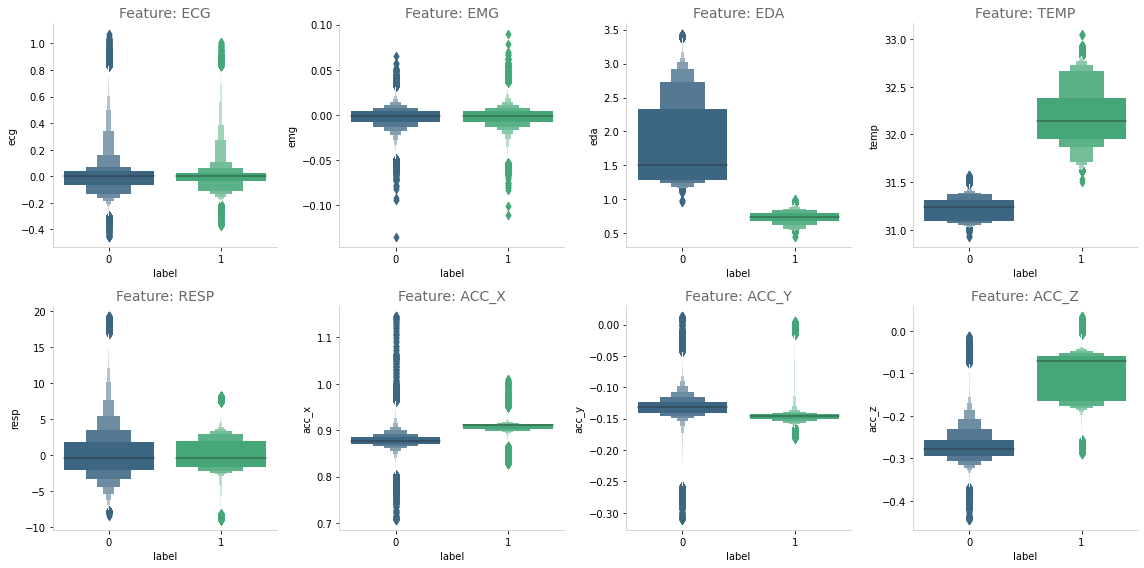

In [4]:
# Visualizando distribuição em boxenplots
features = data.drop('label', axis=1).columns
boxenplot(data, 'label', features, n_rows=2, n_cols=4)

Com a visualização acima, é possível perceber a distribuição de cada uma das medições dos sensores para cada classe do conjunto (sensações de divertimento `(0)` e stress `(1)`). Aqui, é possível destacar a visível diferença encontrada nas medições de Temperatura (`TEMP`), indicando que altas temperaturas corpóreas estão relacionadas a uma sensação de stress. As medições no sensor EDA (Resposta Galvânica da Pele) também indicam uma grande diferença entre as sensações consideradas.

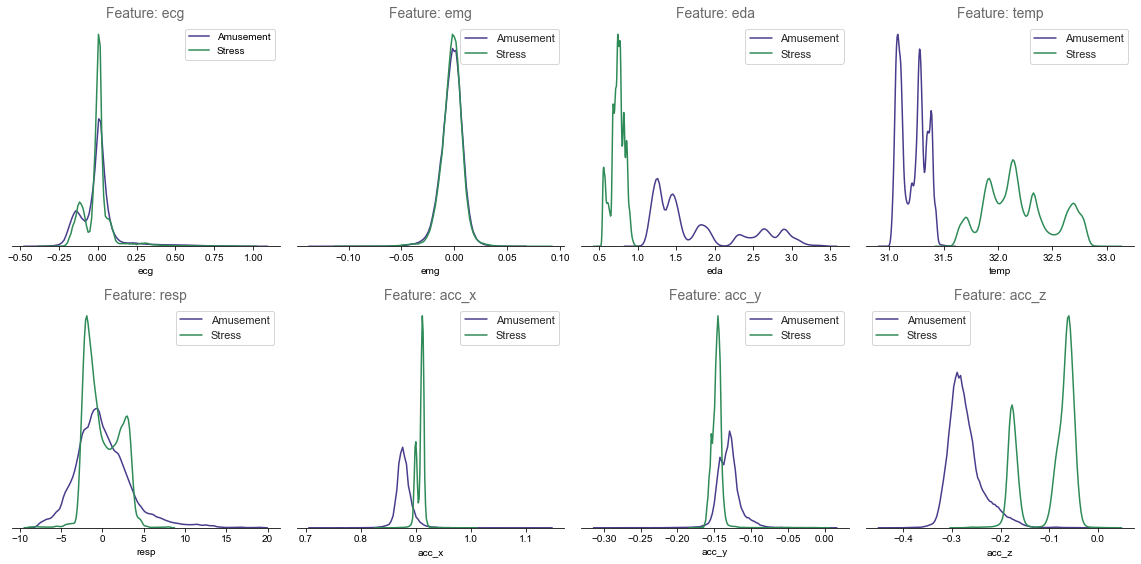

In [5]:
# Visualizando distribuições em histogramas
target_names = ['Amusement', 'Stress']
color_list = ['darkslateblue', 'seagreen']
distplot(data, 'label', target_names, features, color_list, n_rows=2, n_cols=4)

## Correlação entre as Features

Vamos construir uma matriz de correlação entre as variáveis para avaliar se existem features correlacionadas e como estas estão distribuídas no conjunto.

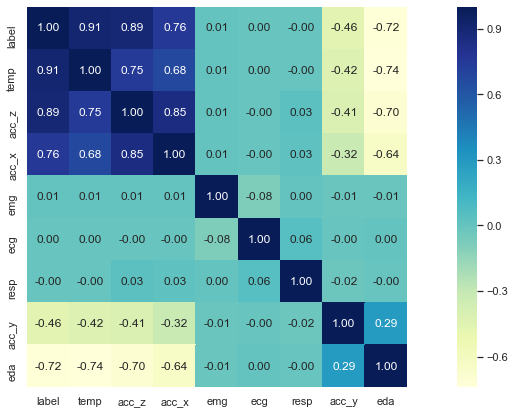

In [6]:
# Mostrando variáveis com maior correlação com a variável resposta
k = 10
label_name = 'label'
correlation_matrix(data, label_name, top_k=k)

Em termos visuais, é possível analisar a correlação entre as variáveis do dataset através de um `pairplot()`.

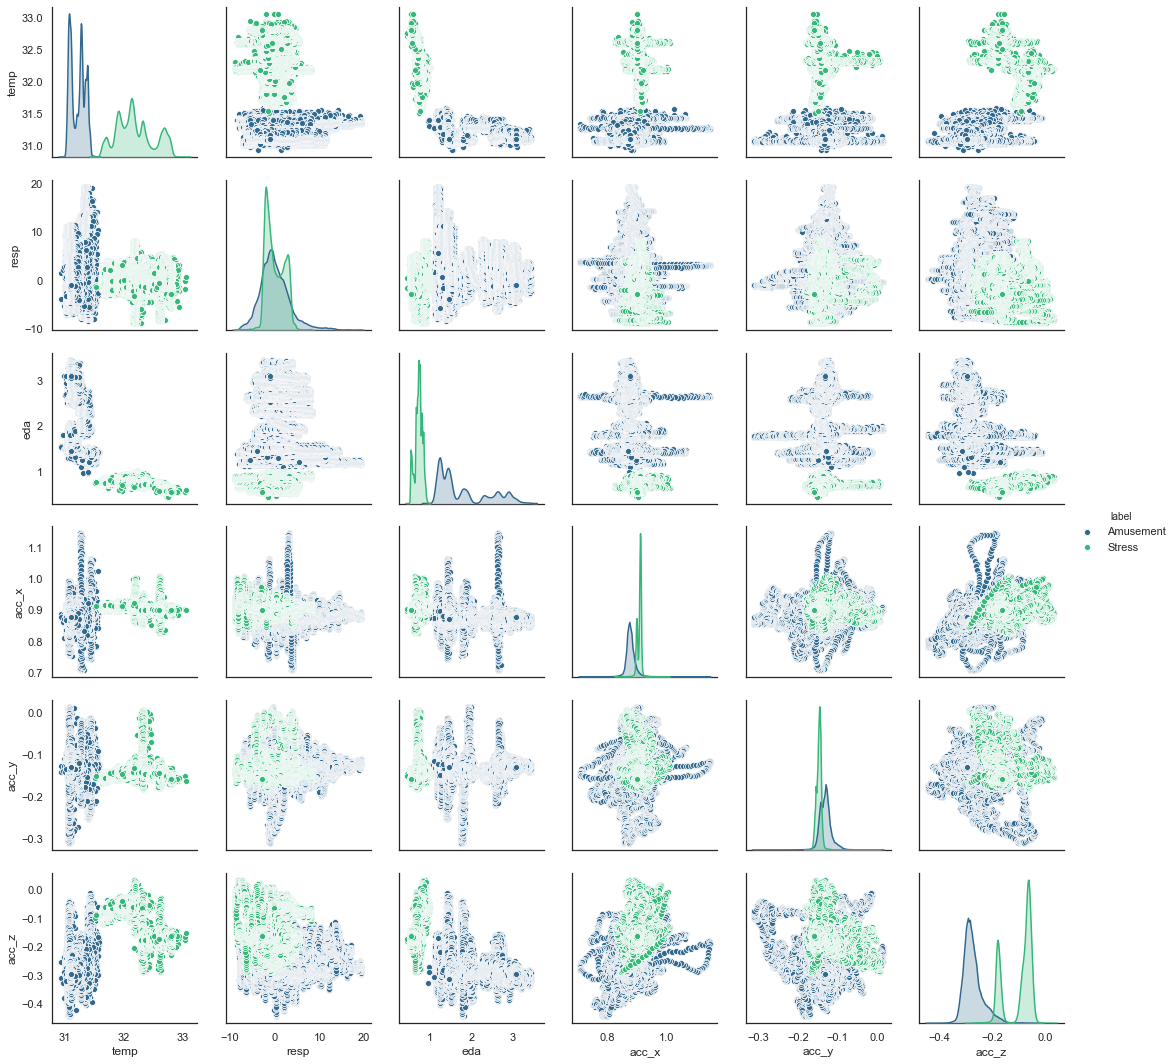

In [7]:
# Pairplot
pairplot_features = ['temp', 'resp', 'eda', 'acc_x', 'acc_y', 'acc_z', 'label']
corr_data = data.loc[:, pairplot_features]
corr_data['label'] = corr_data['label'].map({1: 'Stress', 0: 'Amusement'})
sns.pairplot(corr_data, kind='scatter', hue='label', palette='viridis')
plt.show()

# Agrupamento

Nesta sessão, vamos propor a construção de um algoritmo de Aprendizazdo Não-Supervisionado para clusterizar possíveis sensações baseadas nas medições obtidas pelos sensores disponíveis na base.

Levando em consideração os valores de correlação obtidos a partir da matriz acima, vamos selecionar os sensores de **Temperatura** e **EDA** para uma análise mais detalhada em termos de agrupamento.

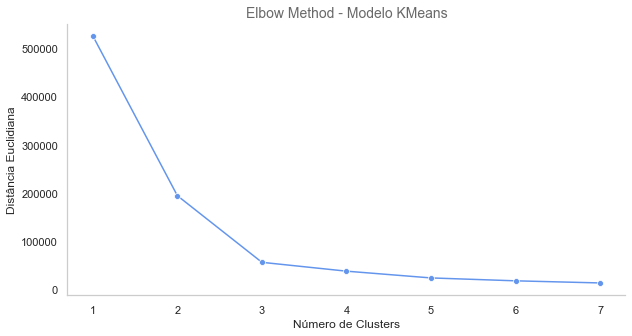

In [8]:
# Definindo melhor número de clusters
columns = ['temp', 'eda']
cluster_data = data.loc[:, columns]
K_min, K_max = 1, 8
elbow_method_kmeans(cluster_data, K_min, K_max)

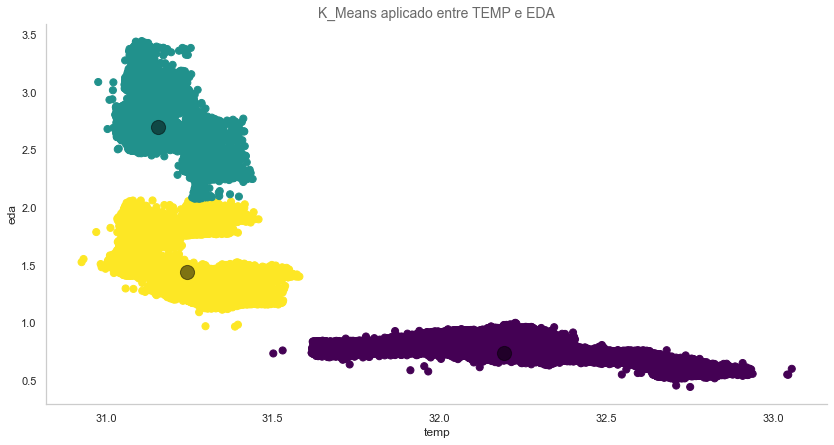

In [9]:
# Treinando algoritmo KMeans
k_means = KMeans(n_clusters=3)
k_means.fit(cluster_data)
y_kmeans = k_means.predict(cluster_data)
centers = k_means.cluster_centers_

# Plotando resultado do agrupamento
plot_kmeans_clusters(cluster_data, y_kmeans, centers)

# Classificação

Após uma análise exploratória para retirada de insights sobre o problema de negócio, o objetivo a ser traçado envolve o treinamento de um modelo de classificação capaz de identificar, a partir de medições de sensores específicos, o provável nível de stress suscetível ao paciente.

In [10]:
# Preparando dados
features = list(data.drop('label', axis=1).columns)
X = data.drop('label', axis=1).values
y = data['label'].values

# Seperando conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
print(f'Dimensões de X_train: {X_train.shape}')
print(f'Dimensões de y_train: {y_train.shape}')

print(f'\nDimensões de X_test: {X_test.shape}')
print(f'Dimensões de y_test: {y_test.shape}')

Dimensões de X_train: (547120, 8)
Dimensões de y_train: (547120,)

Dimensões de X_test: (136780, 8)
Dimensões de y_test: (136780,)


In [11]:
class BinaryBaselineClassifier():

    def __init__(self, baseline_model, X, y, features):
        self.baseline_model = baseline_model
        self.X_train = X
        self.y_train = y
        self.features = features

        self.model_name = baseline_model.__class__.__name__

    def random_search(self, scoring, param_grid=None, tree=True, cv=5):
        """
        Etapas:
            1. definição automática de parâmetros de busca caso o modelo sejá uma Árvore de Decisão
            2. aplicação de RandomizedSearchCV com os parâmetros definidos

        Argumentos:
            scoring -- métrica a ser otimizada durante a busca [string]
            param_grid -- dicionário com os parâmetros a serem utilizados na busca [dict]
            tree -- flag para indicar se o modelo baseline é uma árvore de decisão [bool]

        Retorno:
            best_estimator_ -- melhor modelo encontrado na busca
        """

        # Validando baseline como Árvore de Decisão (grid definido automaticamente)
        if tree:
            param_grid = {
                'criterion': ['entropy', 'gini'],
                'max_depth': [3, 4, 5, 8, 10],
                'max_features': np.arange(1, self.X_train.shape[1]),
                'class_weight': ['balanced', None]
            }

        # Aplicando busca aleatória dos hiperparâmetros
        rnd_search = RandomizedSearchCV(self.baseline_model, param_grid, scoring=scoring, cv=cv, random_state=42)
        rnd_search.fit(self.X_train, self.y_train)

        return rnd_search.best_estimator_

    def fit(self, rnd_search=False, scoring=None, param_grid=None, tree=True):
        """
        Etapas:
            1. treinamento do modelo e atribuição do resultado como um atributo da classe

        Argumentos:
            rnd_search -- flag indicativo de aplicação de RandomizedSearchCV [bool]
            scoring -- métrica a ser otimizada durante a busca [string]
            param_grid -- dicionário com os parâmetros a serem utilizados na busca [dict]
            tree -- flag para indicar se o modelo baseline é uma árvore de decisão [bool]

        Retorno:
            None
        """

        # Treinando modelo de acordo com o argumento selecionado
        if rnd_search:
            print(f'Treinando modelo {self.model_name} com RandomSearchCV.')
            self.trained_model = self.random_search(scoring=scoring)
            print(f'Treinamento finalizado com sucesso! Configurações do modelo: \n\n{self.trained_model}')
        else:
            print(f'Treinando modelo {self.model_name}.')
            self.trained_model = self.baseline_model.fit(self.X_train, self.y_train)
            print(f'Treinamento finalizado com sucesso! Configurações do modelo: \n\n{self.trained_model}')

    def evaluate_performance(self, cv=5):
        """
        Etapas:
            1. medição das principais métricas pro modelo

        Argumentos:
            cv -- número de k-folds durante a aplicação do cross validation [int]

        Retorno:
            df_performance -- DataFrame contendo a performance do modelo frente as métricas [pandas.DataFrame]
        """

        # Iniciando medição de tempo
        t0 = time.time()

        # Avaliando principais métricas do modelo através de validação cruzada
        accuracy = cross_val_score(self.trained_model, self.X_train, self.y_train, cv=cv,
                                   scoring='accuracy').mean()
        precision = cross_val_score(self.trained_model, self.X_train, self.y_train, cv=cv,
                                    scoring='precision').mean()
        recall = cross_val_score(self.trained_model, self.X_train, self.y_train, cv=cv,
                                 scoring='recall').mean()
        f1 = cross_val_score(self.trained_model, self.X_train, self.y_train, cv=cv,
                             scoring='f1').mean()

        # AUC score
        try:
            y_scores = cross_val_predict(self.trained_model, self.X_train, self.y_train, cv=cv,
                                         method='decision_function')
        except:
            # Modelos baseados em árvores não possuem o método 'decision_function', mas sim 'predict_proba'
            y_probas = cross_val_predict(self.trained_model, self.X_train, self.y_train, cv=cv,
                                         method='predict_proba')
            y_scores = y_probas[:, 1]
        # Calculando AUC
        auc = roc_auc_score(self.y_train, y_scores)

        # Finalizando medição de tempo
        t1 = time.time()
        delta_time = t1 - t0
        model_name = self.trained_model.__class__.__name__

        # Salvando dados em um DataFrame
        performance = {}
        performance['acc'] = round(accuracy, 4)
        performance['precision'] = round(precision, 4)
        performance['recall'] = round(recall, 4)
        performance['f1'] = round(f1, 4)
        performance['auc'] = round(auc, 4)
        performance['total_time'] = round(delta_time, 3)

        df_performance = pd.DataFrame(performance, index=performance.keys()).reset_index(drop=True).loc[:0, :]
        df_performance.index = [model_name]

        return df_performance

    def plot_confusion_matrix(self, labels, cv=5, cmap=plt.cm.Blues, normalize=False, figsize=(6, 5)):
        """
        Etapas:

        Argumentos:

        Retorno
        """

        # Realizando predições e retornando matriz de confusão
        y_pred = cross_val_predict(self.trained_model, self.X_train, self.y_train, cv=cv)
        conf_mx = confusion_matrix(self.y_train, y_pred)

        # Plotando matriz
        plt.figure(figsize=figsize)
        sns.set(style='white', palette='muted', color_codes=True)
        plt.imshow(conf_mx, interpolation='nearest', cmap=cmap)
        plt.colorbar()
        tick_marks = np.arange(len(labels))

        # Customizando eixos
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)

        # Customizando entradas
        fmt = '.2f' if normalize else 'd'
        thresh = conf_mx.max() / 2.
        for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
            plt.text(j, i, format(conf_mx[i, j]),
                     horizontalalignment='center',
                     color='white' if conf_mx[i, j] > thresh else 'black')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(self.trained_model.__class__.__name__ + '\nConfusion Matrix', size=14)
        plt.show()

        return conf_mx

    def feature_importance_analysis(self):
        """
        Etapas:
            1. retorno de importância das features
            2. construção de um DataFrame com as features mais importantes pro modelo

        Argumentos:
            None

        Retorno:
            feat_imp -- DataFrame com feature importances [pandas.DataFrame]
        """

        # Retornando feature importance do modelo
        importances = self.trained_model.feature_importances_
        feat_imp = pd.DataFrame({})
        feat_imp['feature'] = self.features
        feat_imp['importance'] = importances
        feat_imp = feat_imp.sort_values(by='importance', ascending=False)
        feat_imp.reset_index(drop=True, inplace=True)

        return feat_imp

    def plot_learning_curve(self, ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10),
                            figsize=(12, 6)):
        """
        Etapas:
            1. cálculo dos scores de treino e validação de acordo com a quantidade m de dados
            2. cálculo de parâmetros estatísticos (média e desvio padrão) dos scores
            3. plotagem da curva de aprendizado de treino e validação

        Argumentos:
            y_lim -- definição de limites do eixo y [int]
            cv -- k folds na aplicação de validação cruzada [int]
            n_jobs -- número de jobs durante a execução da função learning_curve [int]
            train_sizes -- tamanhos considerados para as fatias do dataset [np.array]
            figsize -- dimensões da plotagem gráfica [tupla]


        Retorno:
            None
        """

        # Retornando parâmetros de scores de treino e validação
        train_sizes, train_scores, val_scores = learning_curve(self.trained_model, self.X_train, self.y_train,
                                                               cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

        # Calculando médias e desvios padrão (treino e validação)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        val_scores_std = np.std(val_scores, axis=1)

        # Plotando gráfico de curva de aprendizado
        fig, ax = plt.subplots(figsize=figsize)

        # Resultado em dados de treino
        ax.plot(train_sizes, train_scores_mean, 'o-', color='navy', label='Training Score')
        ax.fill_between(train_sizes, (train_scores_mean - train_scores_std), (train_scores_mean + train_scores_std),
                        alpha=0.1, color='blue')

        # Resultado em validação cruzada
        ax.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Cross Val Score')
        ax.fill_between(train_sizes, (val_scores_mean - val_scores_std), (val_scores_mean + val_scores_std),
                        alpha=0.1, color='crimson')

        # Customizando gráfico
        ax.set_title(f'Modelo {self.trained_model.__class__.__name__} Curva de Aprendizado', size=14)
        ax.set_xlabel('Training size (m)')
        ax.set_ylabel('Score')
        ax.grid(True)
        ax.legend(loc='best')
        plt.show()

## Treinando Modelo

In [12]:
# Inicializando modelo e classe
baseline_model = DecisionTreeClassifier(random_state=42)
ml_tool = BinaryBaselineClassifier(baseline_model, X, y, features)

ml_tool.fit(rnd_search=True, scoring='recall')

Treinando modelo DecisionTreeClassifier com RandomSearchCV.
Treinamento finalizado com sucesso! Configurações do modelo: 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')


## Avaliando Performance

### Métricas

In [13]:
# Avaliando performance
model_performance = ml_tool.evaluate_performance()
model_performance

,acc,precision,recall,f1,auc,total_time
DecisionTreeClassifier,1.0,1.0,1.0,1.0,1.0,19.012


### Matriz de Confusão

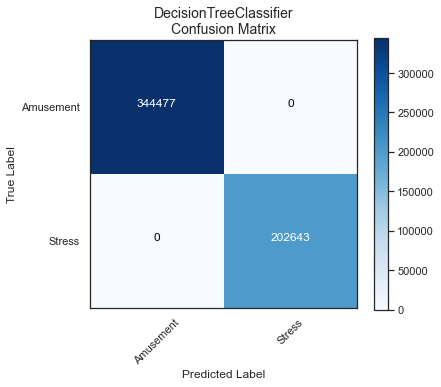

In [14]:
# Plotando e retornando matriz
labels = ['Amusement', 'Stress']
conf_mx = ml_tool.plot_confusion_matrix(labels)

### Feature Importance

In [15]:
# Analisando a importância das features
feat_imp = ml_tool.feature_importance_analysis()
feat_imp

,feature,importance
0,eda,0.999976
1,temp,0.000024
2,ecg,0.000000
3,emg,0.000000
4,resp,0.000000
5,acc_x,0.000000
6,acc_y,0.000000
7,acc_z,0.000000


### Learning Curve

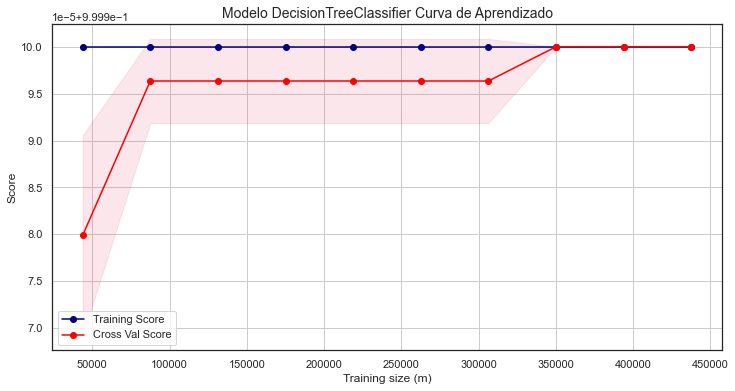

In [16]:
ml_tool.plot_learning_curve()